# The thinking behind this code

1. I have ~200,000 light curves to fit (39 emission lines * 5,052 flares during the MEGS-A era, so that's not even counting other events that MEGS-B may have caught since 2014). 

2. I'm developing routines to fit each light curve independently to reduce the uncertainty. That was originally built as a routine that selected the best fit polynomial between orders 2 and 5. Since converting from IDL to python and reading the Data Science Python Handbook by Jake VanderPlas, I've learned that machine learning algorithms in scikit-learn could be employed instead of a regular polynomial fit. 

3. If I'm already using machine learning algorithms, I may as well take full advantage of what those are for: processing massive amounts of data (e.g., 200,000 light curves), generating models from it, finding patterns within it, and being able to predict. Prediction isn't an obvious application here, but I'll come back to that below. 

4. I'll then have a model trained on my data and can explore the patterns it pulled out. I can classify dimming vs non-dimming lines. Maybe that's what the prediction would be: feed it an "unseen" light curve and ask it to "predict", or classify, whether it is a dimming light curve or not. Also, hopefully there will be some surprises in looking at the results of the trained model. 

5. The ultimate goal is to tie parameters in the light curve to CME speed and mass (and Bz if it was at all possible). I can combine the results of the dimming model with the CDAW (or CacTus or manual or whatever) CME catalogs in another machine learning algorithm to see what correlations it finds between the two sets. 

This code is the tentative, and probably messy, first steps toward the above. 

In [1]:
# Standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io.idl import readsav
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve, ShuffleSplit
from sklearn.metrics import explained_variance_score, make_scorer
from sklearn.svm import SVR

# Custom modules
from jpm_time_conversions import *
from jpm_logger import JpmLogger
%matplotlib inline

/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


First things first: load in the EVE data and get it into a pandas dataframe.

In [2]:
idl_saveset = readsav('/Users/jmason86/Dropbox/Research/Postdoc_LASP/Analysis/Coronal Dimming/Automatic Dimming Database/DimmingIrradiancesEvent1-1520 Python Format.sav')
jedi_saveset = readsav('/Users/jmason86/Dropbox/Research/Postdoc_LASP/Analysis/Coronal Dimming/Automatic Dimming Database/DimmingParametersEvent1-1520 Python Format.sav')

In [3]:
idl_saveset.keys()

dict_keys(['goesclass', 'goespeaktime', 'wavelength', 'irradiance'])

In [4]:
idl_saveset.irradiance.shape

(1641, 242, 39)

In [9]:
wavelengths = idl_saveset.wavelength
wavelengths = wavelengths.astype(str)
wavelengths

array(['94', '131', '133', '171', '177', '180', '195', '202', '211', '256',
       '284', '304', '335', '361', '368', '446', '465', '499', '521',
       '526', '537', '554', '568', '584', '592', '596', '601', '625',
       '630', '719', '722', '770', '790', '836', '950', '973', '977',
       '1026', '1032'], 
      dtype='<U4')

In [10]:
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean', axis=1) # mean of row, axis=0 to use mean of column

In [11]:
irradiance_all_wavelengths = imp.fit_transform(idl_saveset.irradiance[:, :, 0])
for i in range(1, 39):
    line_irradiance = imp.fit_transform(idl_saveset.irradiance[:, :, i])
    irradiance_all_wavelengths = np.concatenate((irradiance_all_wavelengths, line_irradiance), axis=0)
irradiance_all_wavelengths.shape

(63999, 242)

In [33]:
wavelength_cycle = wavelengths
for i in range(0, idl_saveset.irradiance.shape[0] - 1):
    wavelength_cycle = np.concatenate((wavelength_cycle, wavelengths))

In [34]:
light_curve_df = pd.DataFrame(irradiance_all_wavelengths)
#light_curve_df.index = yyyydoy_sod_to_datetime(idl_saveset.yyyydoy, idl_saveset.sod) # Convert EVE standard time to datetime

In [35]:
light_curve_df.head()

,0,1,2,3,4,5,6,7,8,9,...,232,233,234,235,236,237,238,239,240,241
0,0.577683,0.291299,1.128329,7.646937,14.944111,16.822920,22.339363,22.647514,21.029741,18.219797,...,0.654133,0.867133,1.267743,1.504681,0.878097,1.674166,1.351353,1.789718,2.122885,2.122885
1,-0.661931,-1.022377,-0.714036,-0.182564,-1.287462,0.606233,0.801145,1.244728,2.604825,5.605963,...,0.654133,0.867133,1.267743,1.504681,0.878097,1.674166,1.351353,1.789718,2.831939,2.831939
2,-0.456588,-0.384706,0.846144,0.492805,2.006457,6.479109,8.590379,13.075768,13.984530,14.319677,...,1.645827,1.874251,2.056079,0.541185,0.994883,1.620562,1.416975,0.794415,1.410009,1.410009
3,0.421280,1.318743,1.191174,1.722479,1.387573,1.732213,1.956383,1.562194,2.740653,2.210717,...,0.018099,1.588918,0.242384,1.004780,0.542430,2.054761,0.458638,0.900684,3.443783,3.443783
4,2.298044,1.069474,1.676226,2.851308,6.976572,14.525224,31.303625,46.920063,45.038712,38.490543,...,-0.365485,-0.587790,-0.869914,-0.136591,-0.528685,-2.057295,-1.667459,-0.360936,3.937440,3.937440


In [36]:
light_curve_df.shape

(63999, 242)

In [37]:
from sklearn.decomposition import PCA  # Step 1: choose model class
model = PCA(n_components=2)            # Step 2: instantiate model, hyperparameter to reduce to two axes/features/components
model.fit(light_curve_df)              # Step 3: fit model to data
X_2D = model.transform(light_curve_df) # Step 4: transform data to two dimensions

In [38]:
depth = jedi_saveset.depth
depth_all_wavelengths = depth.ravel()
depth_all_wavelengths = np.nan_to_num(depth_all_wavelengths)
is_dimming = (depth_all_wavelengths > 1) & (depth_all_wavelengths < 50)

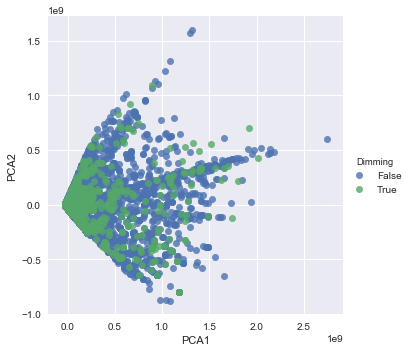

In [41]:
light_curve_results_df = light_curve_df
light_curve_results_df['PCA1'] = X_2D[:, 0]
light_curve_results_df['PCA2'] = X_2D[:, 1]
light_curve_results_df['Wavelength'] = wavelength_cycle
light_curve_results_df['Dimming'] = is_dimming
sns.lmplot("PCA1", "PCA2", data=light_curve_df, hue='Dimming', fit_reg=False);

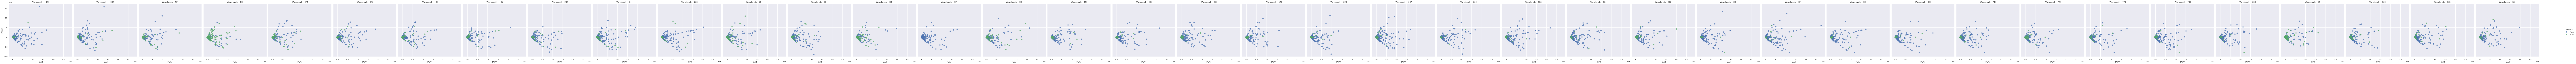

In [42]:
sns.lmplot("PCA1", "PCA2", data=light_curve_df, hue='Dimming', col='Wavelength', fit_reg=False);

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(light_curve_df, is_dimming)

In [43]:
from sklearn.mixture import GaussianMixture # Step 1: choose model class
model = GaussianMixture(n_components=3,
            covariance_type='full')        # Step 2: instantiate model, hyperparameters to return 3 groups, each component has its own covariance matrix
model.fit(light_curve_df)                  # Step 3: fit to data, again model knows nothing about species (target vector, y)
y_gmm = model.predict(light_curve_df)      # Step 4: determine cluster labels

ValueError: Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.

In [ ]:
light_curve_results_df['cluster'] = y_gmm
sns.lmplot("PCA1", "PCA2", data=light_curve_df,
           col='cluster', fit_reg=False);

In [ ]:
light_curve_df.iloc[0:3,0:4]